In [2]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import defaultdict

In [3]:
file_path = 'gauss_geomagnetism_preface.txt' #テキストを開く
with open(file_path, encoding='utf-8') as f:
    t = f.read()

paragraphs = t.split('\n\n')[:-1] #段落ごとに分割（今回の分析単位）

mod_paragraphs = []
for p in paragraphs:
    p = re.sub(r'\n', '', p) #段落内の改行を削除
    p = re.sub(r'\{.*\}', '', p) #LaTex形式の数式を削除
    p = re.sub(r'\[\d+\]', '', p) #注番号を削除
    p = re.sub(r'\d+', '', p) #数字だけのものを削除
    p = re.sub(r'[,，]', '', p) #カンマを削除
    p = re.sub(r'[;；]', '', p) #セミコロンの削除
    p = re.sub(r'[:：]', '', p) #コロンの削除
    p = re.sub(r' [\(\)]', '', p) #括弧の削除
    p = re.sub(r'\.', '', p) #ピリオドの削除
    mod_paragraphs.append(p)

In [4]:
from nltk.corpus import stopwords #各段落の文章をトークンに分割
token_for_p = []
stopwords1 = stopwords.words('english')
stopwords2 = [')']
stopwords = stopwords1 + stopwords2

for paragraph in mod_paragraphs:
    l_paragraph = paragraph.lower()
    tokens = nltk.word_tokenize(l_paragraph)
    tokens = [token for token in tokens if token not in stopwords]
    token_for_p.append(tokens)

In [5]:
import collections #各段落で頻出上位15単語を特徴単語として抽出
common_word_for_p = []

for tokens in token_for_p:
    ct = collections.Counter(tokens)
    cw = ct.most_common()[:15]
    common_word_for_p.append(cw)

In [6]:
sent_vectorized = [] #特徴単語を結合することで各段落を文にする

for common_words in common_word_for_p:
    sent = ' '.join([x for (x, y) in common_words])
    sent_vectorized.append(sent)

In [7]:
vectorizer = TfidfVectorizer() #ベクトル化
X = vectorizer.fit_transform(sent_vectorized)
vecs = X.toarray()

In [8]:
import numpy as np #コサイン類似度の計算

cosins_li = [[0 for i in range(len(vecs))] for i in range(len(vecs))]

for i in range(len(vecs)):
    for j in range(len(vecs)):
        cosins_li[i][j] = np.dot(vecs[i], vecs[j]) / np.linalg.norm(vecs[i]) * np.linalg.norm(vecs[j])

In [9]:
import itertools as itt 
a = [i for i in range(len(vecs))]
nums = list(itt.combinations(a, 2))

distance_for_words = defaultdict(float)

for (x, y) in nums:
    distance_for_words[(x, y)] = cosins_li[x][y]

In [10]:
distance_list = sorted(distance_for_words.items(), key=lambda x:x[1], reverse=True)

In [13]:
import pandas as pd

para_1 = []
para_2 = []
coef = []

for((x, y), z) in distance_list:
    para_1.append(x)
    para_2.append(y)
    coef.append(z)
    
df = pd.DataFrame({'para_1':para_1, 'para_2':para_2, 'coef':coef}) 
weighted_edges = np.array(df) #重みづけ用のデータ

In [14]:
import matplotlib.pyplot as plt 
import networkx as nx
%matplotlib inline

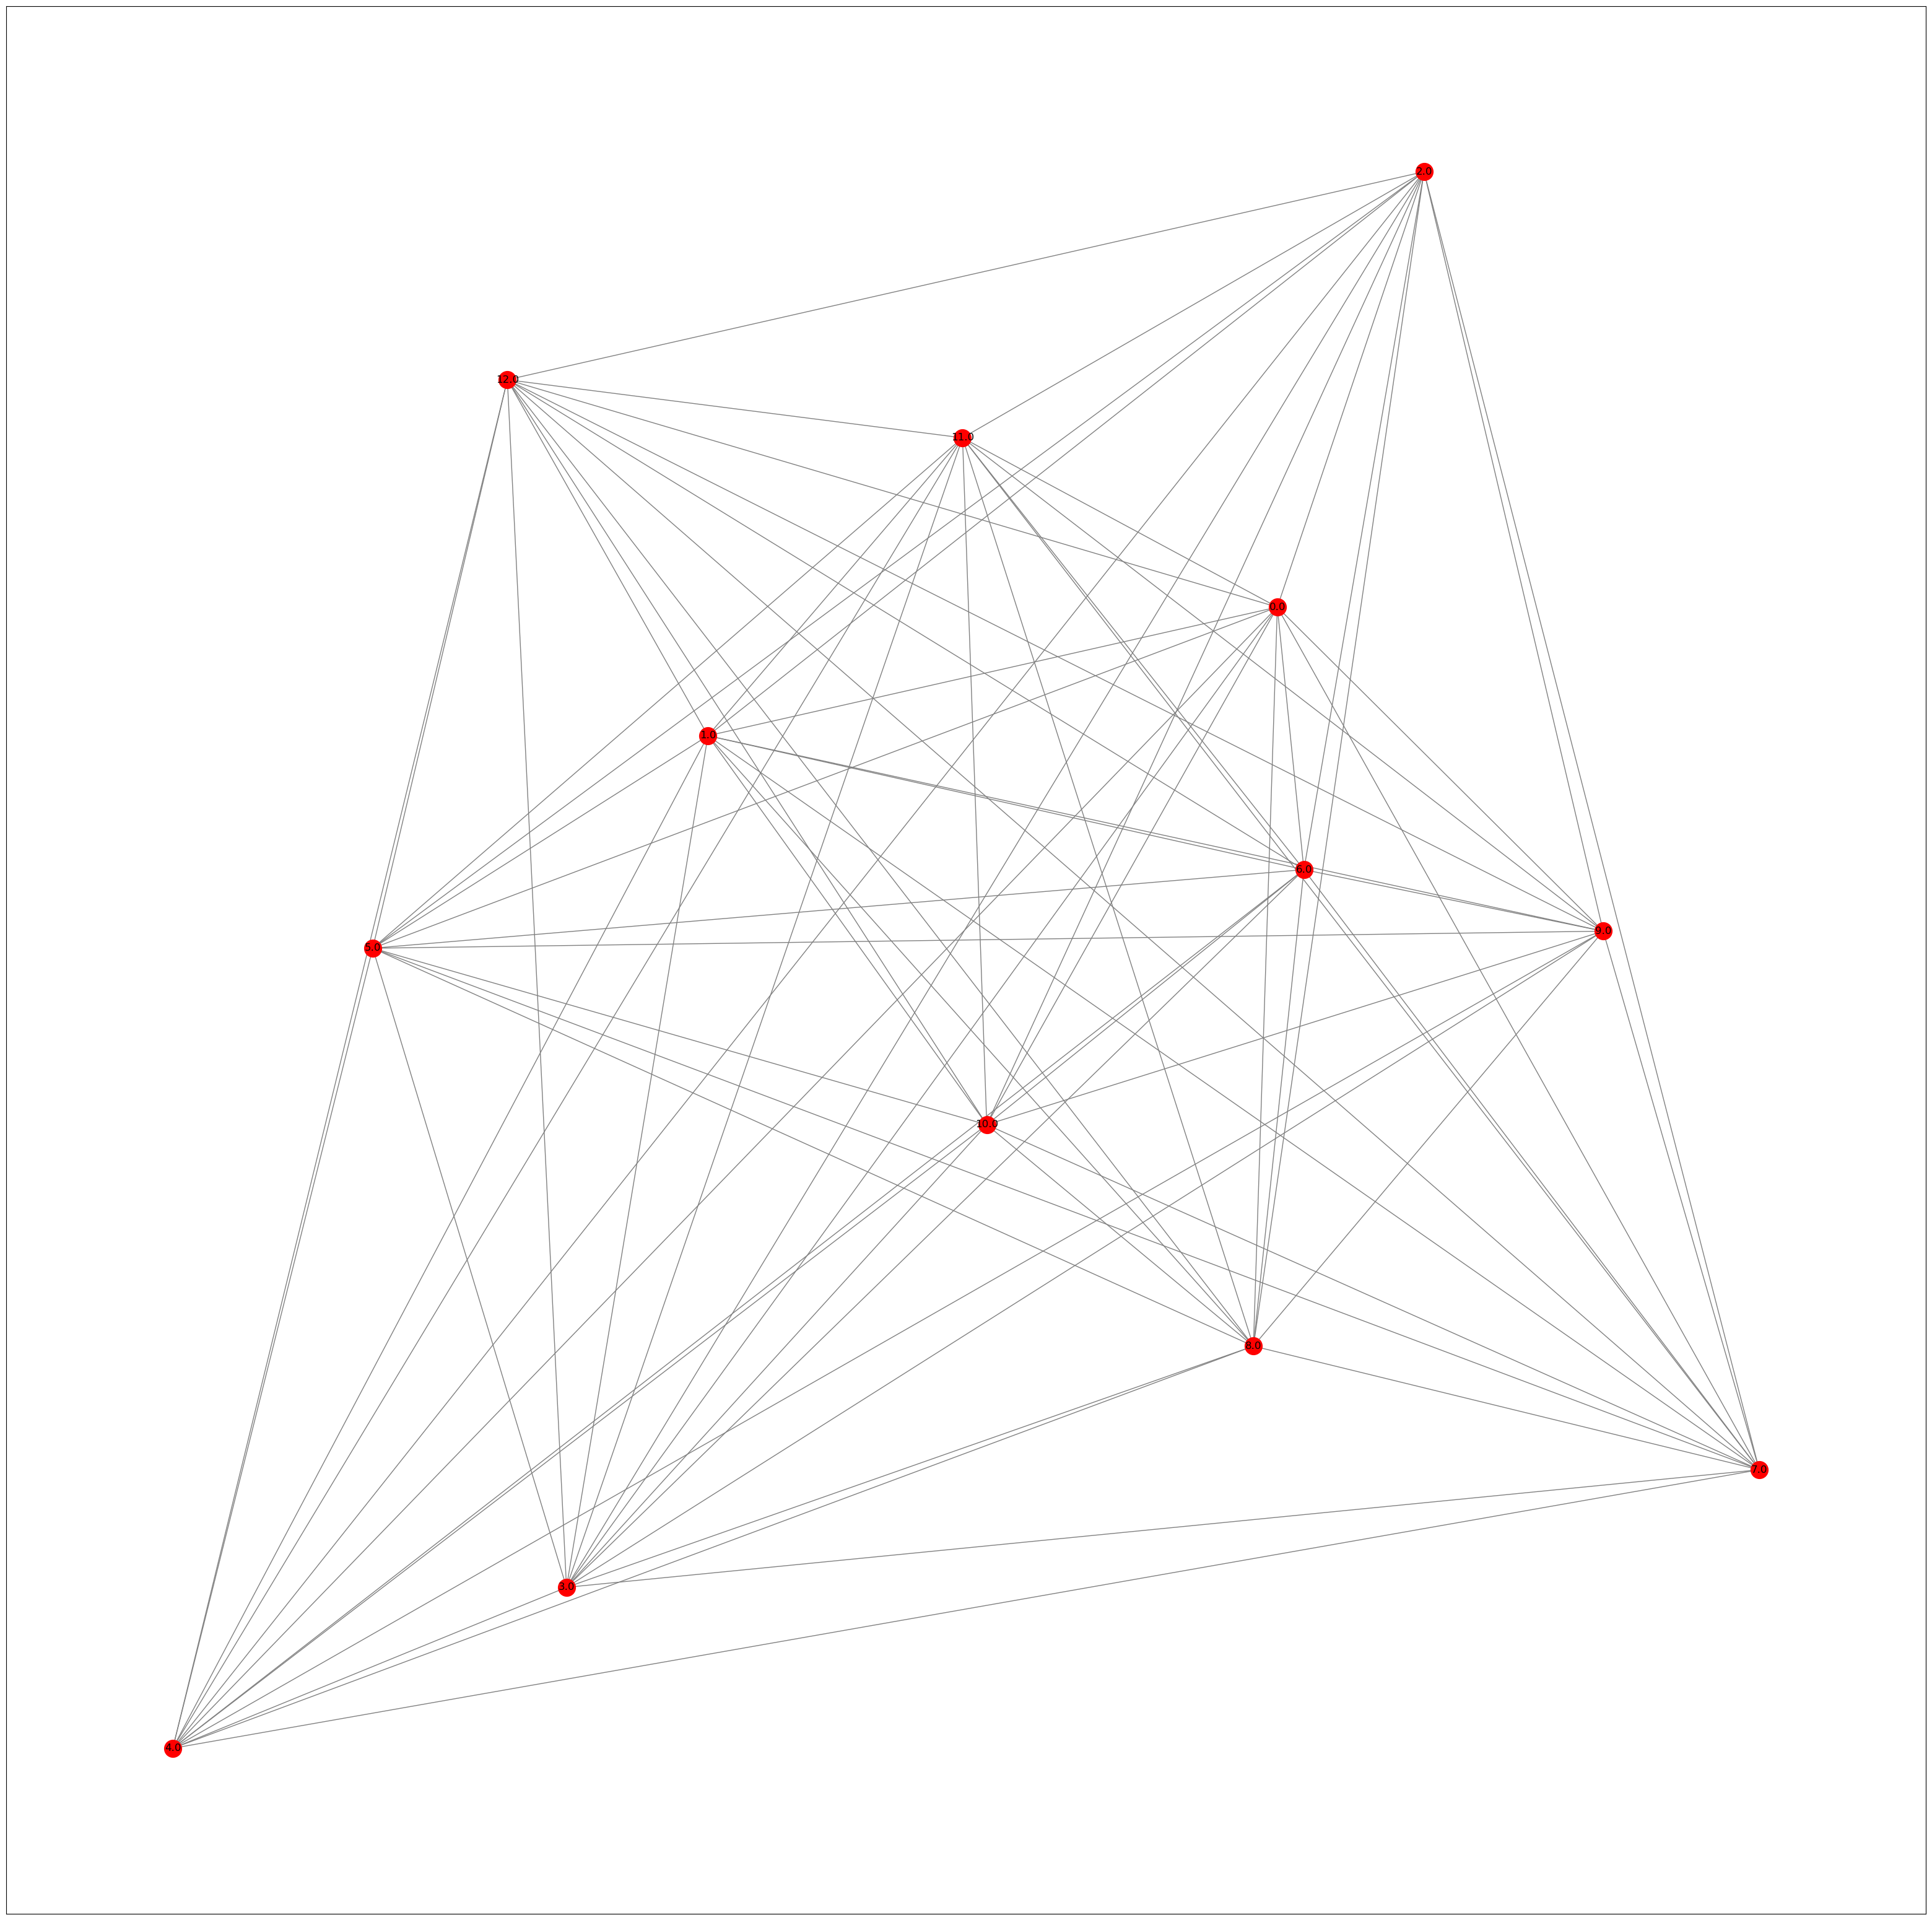

In [26]:
G = nx.Graph() 

G.add_weighted_edges_from(weighted_edges) #重みづけ用データの代入

plt.figure(figsize=(40, 40)) #お好みの設定で
nx.draw_networkx(G, node_shape = 'o', node_color = 'r', node_size = 400, edge_color = 'gray', font_family = 'DejaVu Sans')
plt.show()